# Однофакторный анализ связи меток кред и фрод дефолта target.class с данными таблиц Фед ресурса efrsfdu базы данных VLS-MDM-DB MDM_Main по фичам (часть 3)

- 'duration_max' - максимальная длительность закрытых договоров
- 'duration_min' - минимальная длительность закрытых договоров
- 'duration_mean' - средняя длительность закрытых договоров

Входные данные data/interm/target_features.pkl из feature_engineering.ipynb уже рассчитанные фичи

In [1]:
import pandas as pd

In [2]:
pre = '../../' # путь до главной директории проекта

%run ../init.ipynb #подгрузить нужные библиотеки
%run ../params.ipynb #параметры как логин пароль к БИ, параметры расчёта ( в нашем случае их нет)
%run ../init_mdm.ipynb
%run ../preprocessing/preprocessing_target.ipynb
%run ../ML_functions.ipynb
%run ../auxiliary/plots.ipynb

In [3]:
name = pre + "data/interm/target_features.pkl"
target_features = pd.read_pickle(name, compression={'method':'zip'})

print("Размер считанных данных target_class with mdm features- {}".format(target_features.shape))

Размер считанных данных target_class with mdm features- (85798, 39)


In [4]:
# сюда таблицы будем кидать, для отчетов
name = pre + "data/interm/auxilary/analysis_features_part3.xlsx"
writer = ExcelWriter(name)

In [5]:
# target_features.head(2)

#### Теперь формируем выборки для фрод и кред дефолта

In [6]:
target_frod = Target(type='фрод', target_data=target_features, removeMajorClients=True) # это фрод дефолт, макс по обращению без крупных клиентов

target_frod.print_param()

target_cred = Target(type='кред', target_data=target_features, removeMajorClients=True) # это кред дефолт, макс по обращению без крупных клиентов

target_cred.print_param()


Параметры обработанной таблицы портфеля рисков  по обращениям:
	фрод дефолт = 1  у выборки 4428 из 54288 (8.16%)

Параметры обработанной таблицы портфеля рисков  по обращениям:
	кред дефолт = 1  у выборки 1566 из 37898 (4.13%)


In [7]:
# target_frod.data.head(2)

In [8]:
%run ../auxiliary/plots.ipynb

In [9]:
data = target_frod.data
type_default = 'фрод'

# #  timedelta с делаем в днях и числовыми значениями
# data = days_substitute(data)

In [10]:
feature = 'duration_min'
num_groups_wanted = 20
base_data = data

featureProperty = allFeaturesProperties[feature]

if featureProperty['for_closed']:
    base_data = base_data[base_data['no_contracts_closed']>0]
elif feature in ['contract_date_delta_first', 'contract_date_delta_last']:
    base_data = base_data[base_data[feature]>0]
    

bins = base_data[feature].quantile(np.array(range(0, num_groups_wanted+1))/num_groups_wanted).unique()

if featureProperty['type'] !='float': 
    bins = list(set(bins.astype(int)))

bins.sort()
n_bins = len(bins)


In [11]:
target_frod.data.dtypes

index                                               int64
Приложение                                         object
Номер сделки                                       object
Номер договора (кратко)                            object
ИНН контрагента                                    object
Дата принятия решения по сделке            datetime64[ns]
Метка фрод дефолта                                  int64
Метка кред дефолта                                  int64
Попадает в выборку                                 object
DATE_ACTUAL                                datetime64[ns]
NL_NEW_PRODUCTNAME                                 object
O_NEW_TOTALFINANCINGSUM                           float64
no_contracts_active                               float64
no_transp_active                                  float64
no_contracts_total                                float64
no_transport_total                                float64
no_contracts_closed                               float64
reason_гибель/

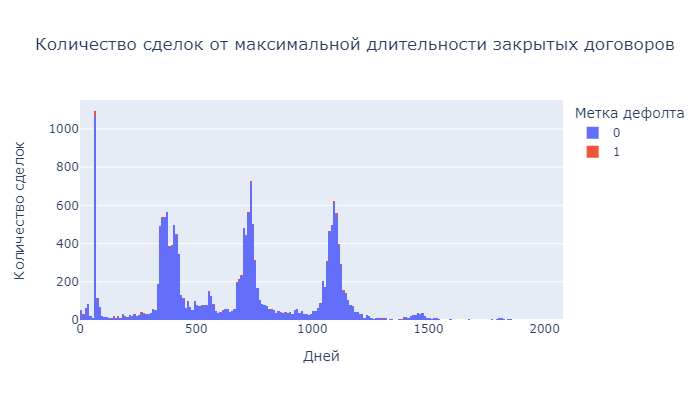

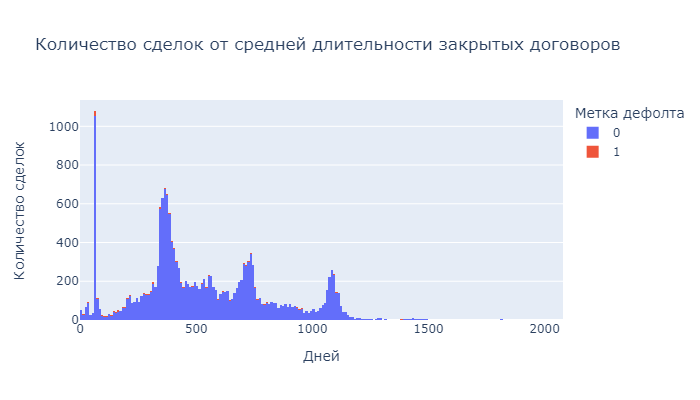

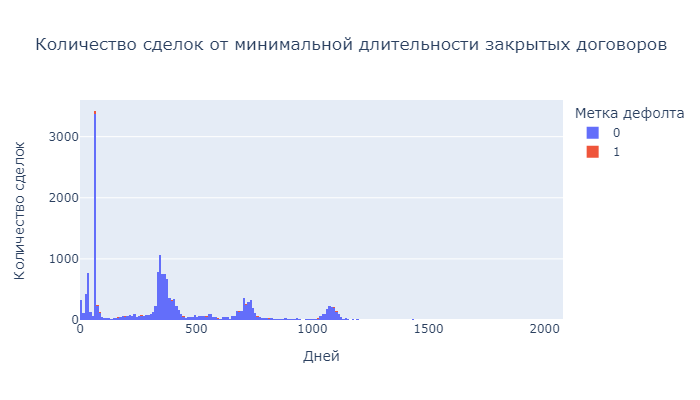

In [12]:
fig = show_duration(target_frod.data, x='duration_max', title='Количество сделок от максимальной длительности закрытых договоров')
fig = show_duration(target_frod.data, x='duration_mean', title='Количество сделок от средней длительности закрытых договоров')
fig = show_duration(target_frod.data, x='duration_min', title='Количество сделок от минимальной длительности закрытых договоров')

In [13]:
#  статиcтика по фичам
stat = target_frod.data['duration_max'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_max':'frod_duration_max'})
stat = stat.append(target_frod.data['duration_mean'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_mean':'frod_duration_mean'}))
stat = stat.append(target_frod.data['duration_min'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_min':'frod_duration_min'}))

stat['max'] = stat['max'].apply(strfdelta, fmt='{Y}years {D:02}days')
stat['mean'] = stat['mean'].apply(strfdelta, fmt='{Y}years {D:02}days')
stat['std'] = stat['std'].apply(strfdelta, fmt='{Y}years {D:02}days')

stat.to_excel(writer, sheet_name='stat_features')

stat

,min,max,mean,std
frod_duration_max,0 days,5years 253days,1years 304days,0years 355days
frod_duration_mean,0 days,5years 253days,1years 169days,0years 295days
frod_duration_min,0 days,5years 253days,1years 24days,0years 323days


In [14]:
#  статиcтика по фичам
stat = target_cred.data['duration_max'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_max':'frod_duration_max'})
stat = stat.append(target_cred.data['duration_mean'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_mean':'frod_duration_mean'}))
stat = stat.append(target_cred.data['duration_min'].apply(['min', 'max', 'mean', 'std']).to_frame().T.rename({'duration_min':'frod_duration_min'}))

stat['max'] = stat['max'].apply(strfdelta, fmt='{Y}years {D:02}days')
stat['mean'] = stat['mean'].apply(strfdelta, fmt='{Y}years {D:02}days')
stat['std'] = stat['std'].apply(strfdelta, fmt='{Y}years {D:02}days')

stat.to_excel(writer, sheet_name='stat_features_cred')

stat

,min,max,mean,std
frod_duration_max,0 days,5years 253days,1years 263days,0years 344days
frod_duration_mean,0 days,5years 253days,1years 138days,0years 286days
frod_duration_min,0 days,5years 253days,1years 04days,0years 311days


## LogRegression от продолжительности договоров на день принятия решения по нашей сделке

### Дефолтные сделки duration_max по всем закрытым договорам до даты принятия решения (фрод метка)

{'rocauc': 0.57, 'accuracy': 0.56, 'recall': 0.57}
{'intercept': -0.0374, 'coef': array([-0.262])}


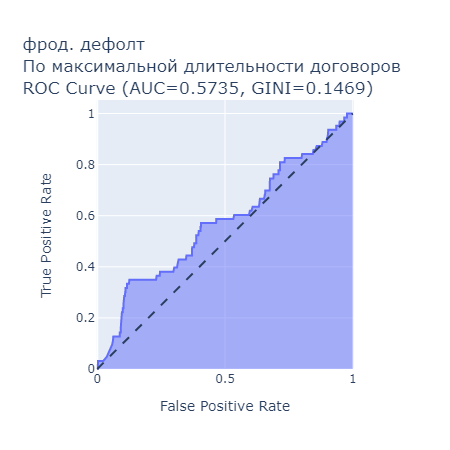

In [15]:
type = target_frod.type

df = target_frod.data[target_frod.data['duration_max'].notnull()].copy()
df['duration_days'] = df['duration_max'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По максимальной длительности договоров')

{'rocauc': 0.54, 'accuracy': 0.47, 'recall': 0.62}
{'intercept': -0.0193, 'coef': array([-0.1854])}


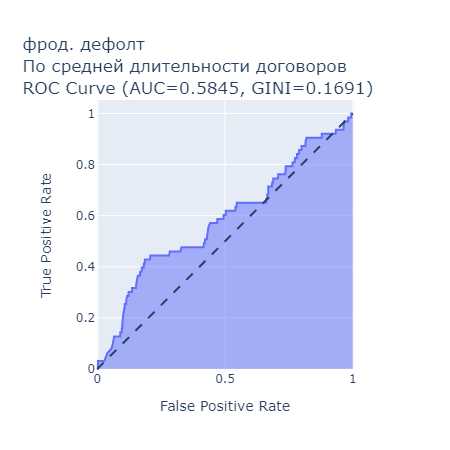

In [16]:
type = target_frod.type

df = target_frod.data[target_frod.data['duration_mean'].notnull()].copy()
df['duration_days'] = df['duration_mean'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По средней длительности договоров')

{'rocauc': 0.52, 'accuracy': 0.37, 'recall': 0.67}
{'intercept': -0.0003, 'coef': array([-0.0227])}


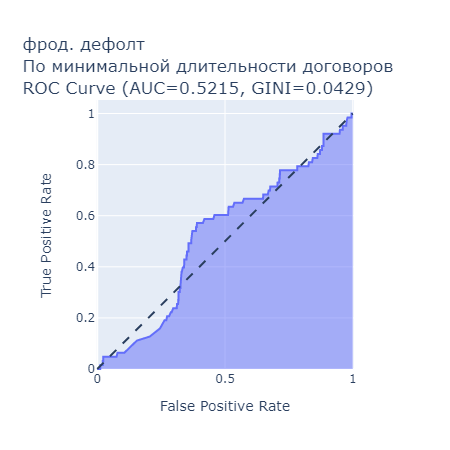

In [17]:
type = target_frod.type

df = target_frod.data[target_frod.data['duration_min'].notnull()].copy()
df['duration_days'] = df['duration_min'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По минимальной длительности договоров')

# Log - regression по меткам кред дефолта

In [18]:
# target_cred.data.head(1)

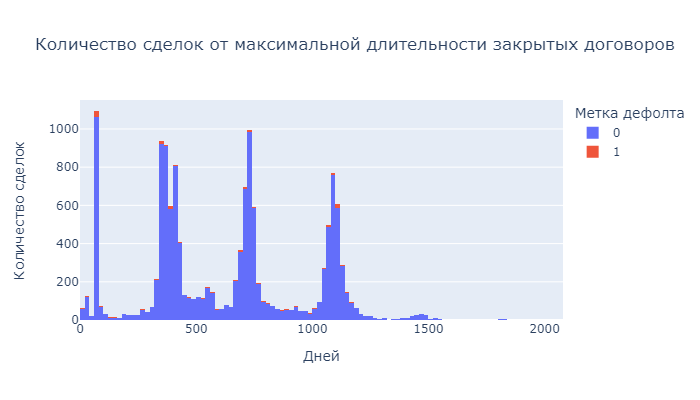

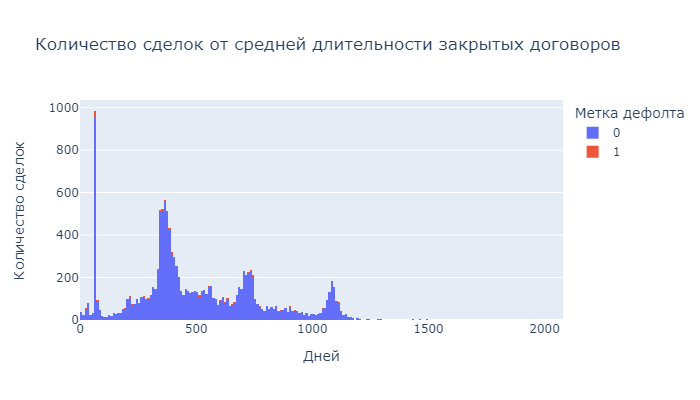

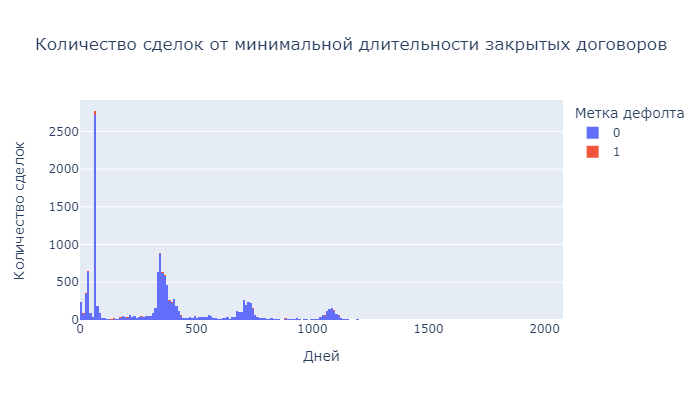

In [19]:
fig = show_duration(target_cred.data, x='duration_max', title='Количество сделок от максимальной длительности закрытых договоров')
fig = show_duration(target_cred.data, x='duration_mean', title='Количество сделок от средней длительности закрытых договоров')
fig = show_duration(target_cred.data, x='duration_min', title='Количество сделок от минимальной длительности закрытых договоров')

### Дефолтные сделки duration_max по всем закрытым договорам до даты принятия решения (кред метка)

{'rocauc': 0.51, 'accuracy': 0.49, 'recall': 0.53}
{'intercept': -0.0007, 'coef': array([0.036])}


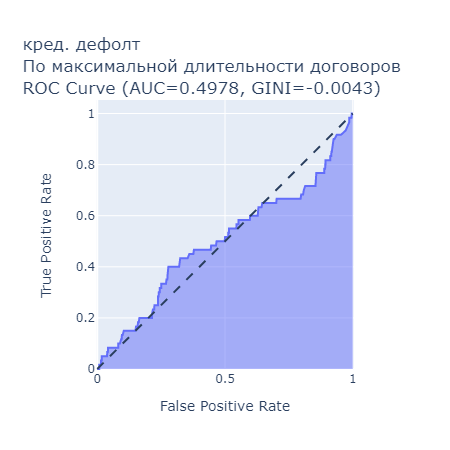

In [20]:
type = target_cred.type

df = target_cred.data[target_cred.data['duration_max'].notnull()].copy()
df['duration_days'] = df['duration_max'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По максимальной длительности договоров')

{'rocauc': 0.48, 'accuracy': 0.56, 'recall': 0.38}
{'intercept': -0.0003, 'coef': array([0.0251])}


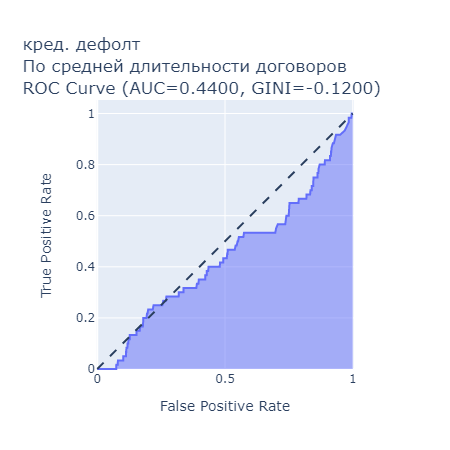

In [21]:
type = target_cred.type

df = target_cred.data[target_cred.data['duration_mean'].notnull()].copy()
df['duration_days'] = df['duration_mean'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По средней длительности договоров')

{'rocauc': 0.46, 'accuracy': 0.59, 'recall': 0.32}
{'intercept': -0.0, 'coef': array([0.003])}


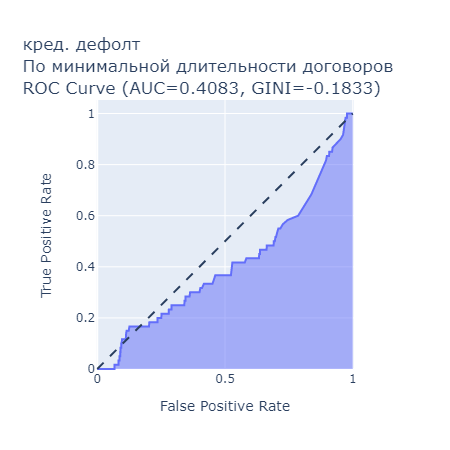

In [22]:
type = target_cred.type

df = target_cred.data[target_cred.data['duration_min'].notnull()].copy()
df['duration_days'] = df['duration_min'].dt.days

X_raw = np.asarray(df[['duration_days']])
y = np.asarray(df['Метка дефолта'])

log = LogReg(X_raw, y)

log.print_metrics()
log.print_coef()
fig = log.plot_roc_curve(title = '{}. дефолт'.format(type) + '<br>' +'По минимальной длительности договоров')

In [23]:
# сохраняем tmp таблицы
if len(writer.sheets):
    writer.save()